In [1]:
data_path = './data'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# read symbos from file first line

def get_sym_name(filename):
    import re
    with open(filename) as f:
        firstline = f.readline()
        symbols = re.split(r'\s', firstline)
    
    return(symbols[0], symbols[1])

In [4]:
'''
从通达信导出文件中获取数据
返回值为pandas dataframe 和 证券代码
'''
def load_data(filename):
    code, name = get_sym_name(filename)
   
    data = pd.read_csv(filename, skiprows=1, encoding='GBK', index_col=0, parse_dates=True,sep='\t')
    # the last line contains no data, the last column contains 成交额
    data = data.iloc[:-1, :5]
    
    data.columns = ['open', 'high', 'low', 'close', 'vol']
    data.index.names=['date']
    return('%s:%s' %(name, code), data)

In [5]:
def load_dir(dir_name, count =0):
    import os
    keys = []
    datas = []
    
    file_count = 0
    for file in os.listdir(dir_name):
        fn = '{0}/{1}'.format(dir_name, file)
        
        name, data=load_data(fn)
        keys.append(name)
        data.insert(0, 'symbol', name)
        datas.append(data)
        file_count = file_count +1
        if file_count == count :
            break
        
    return(pd.concat(datas).sort_index())




In [6]:
def calc_atr(data, window=20):
    o = data.open
    h = data.high
    l = data.low
    c = data.close
    
    pc= c.shift(1)
    indicator = pd.DataFrame({'hl':h-l, 'lc':(l-pc).abs(), 'hc': (h-pc).abs()})
    tr = indicator.max(axis=1, skipna=False)
    
    atr = tr.rolling(window).mean()
    return(atr)

    

In [7]:
def ma(data, window=10):
    return(data.rolling(window).mean())


In [8]:
def ma_ind(close, swin=10, mwin=50, lwin=200):
    sma = ma(close,swin)
    mma = ma(close, mwin)
    lma= ma(close, lwin)
    indicator = np.logical_and(sma>lma,sma > mma)
    indicator[lma.isnull()] = np.NaN
    return(sma, mma, lma,indicator)

# _,_,_,ind= ma_ind(data.close)


In [42]:
def close_ind(close, swin=10, mwin=50, lwin=200):
    sma = ma(close,swin)
    mma = ma(close, mwin)
    lma= ma(close, lwin)
    indicator = ((close>mma)&  (mma>lma) ).apply(int)
    indicator[lma.isnull()] = np.NaN
    return(sma, mma, lma,indicator)

In [10]:
def daily_ret(data):
    prev_close = data.close.shift(1)
    ret = data.close/ prev_close -1
    return(ret)

#ret = daily_ret(data)
#pd.DataFrame({'c':data.close,'pc': data.close.shift(1), 'ret':ret}).iloc[:100]

In [46]:
def init_back_data(data, swin, mwin, lwin):
    c = data.close
    atr = calc_atr(data)
    ret = daily_ret(data)
    #_, _, _, ind = ma_ind(c, swin, mwin, lwin)
    sma, mma, lma, ind = close_ind(c, swin, mwin, lwin)
    new_df = pd.DataFrame({'c':c, 'atr': atr, 'ret':ret, 'ind':ind, 'sma':sma, 'lma':lma, 'mma': mma})
    new_df = new_df.dropna()
    new_df.index = pd.to_datetime(new_df.index)
    return(new_df)



In [43]:
def calc_canhold(account_value,atr,loss_fac = 0.02, atr_fac=2):
    max_loss = account_value * loss_fac
    t_atr = atr_fac * atr
    return(np.floor(max_loss/t_atr/100)*100)

In [ ]:
def day_trade(day, account, indicator, close, hold)

In [113]:
def back_test(df, start='2015', to = '2019'):
    test_data = df[start:to].copy()
    prev_hold = 0
    hold = 0
    prev_cash = 100000
    test_data['cash'] = 0
    test_data['hold'] = 0
    test_data['value'] = 0
    test_data['drawdown'] = 0.0
    test_data['cur_max'] = 0
    
    # for drawdown calc
    start_at = None
    end_date = None
    from math import floor
    for index,row in test_data.iterrows():
        atr = row['atr']
        ind = row['ind']
        close = row['c']
        hold= prev_hold
        acc_val= close*hold + prev_cash
        if ind== 1 :
            can_hold = calc_canhold(acc_val, atr, loss_fac = 0.02, atr_fac=5 )

            hold_diff = can_hold - prev_hold

            if abs(hold_diff) > 1000 :
                cash =prev_cash - hold_diff * close
                if cash > 0:
                    hold = hold + hold_diff
                else:
                    r_diff = floor(prev_cash / (close*100))*100 
                    hold = r_diff + hold
                    cash = prev_cash - r_diff * close
                
                # drawdown calc
                if prev_hold == 0 :
                    start_at = index
                    print('start_at:', start_at)

                #print('day:{3}  cash:{0}, hold:{1}, diff:{2}'.format(cash, hold, hold_diff, index))

        elif hold > 0:
            # sell all
            cash = prev_cash + hold * close
            hold = 0
            end_date = index
            print('end_at:', end_date)
            #print('day:{2}  cash:{0}, hold:{1}'.format(cash, hold, index))
        else:
            cash = prev_cash
            hold = prev_hold

        prev_cash = cash
        prev_hold = hold
        
        
        curr_equation = cash  + hold * close
        if (not start_at is None) and start_at != index:
            curr_trans_max_value = test_data.value[start_at:index].max()
            if hold == 0:
                start_at = None
                assert(end_date == index)
        else:
            curr_trans_max_value = curr_equation
            

        if curr_trans_max_value > 0  :
            drawdown = 1- curr_equation/curr_trans_max_value
        else:
            drawdown = 0
            
        if drawdown > 0.1 :
            cash = prev_cash + hold * close
            hold = 0
            end_date = index
            curr_equation = cash
            start_at  = None
            print('trail stop at:', end_date )
        
        test_data.at[index,'cash'] = cash
        test_data.at[index, 'hold'] = hold
        test_data.at[index, 'cur_max'] = curr_trans_max_value
        test_data.at[index, 'value'] = curr_equation
        test_data.at[index, 'drawdown'] =drawdown
        
    return test_data
            
        

In [114]:
swin = 10
mwin = 60
lwin = 120


中:159902
start_at: 2017-06-07 00:00:00
end_at: 2017-11-27 00:00:00
start_at: 2018-01-04 00:00:00
end_at: 2018-01-05 00:00:00
start_at: 2018-01-09 00:00:00
end_at: 2018-01-10 00:00:00
start_at: 2018-01-11 00:00:00
end_at: 2018-01-15 00:00:00
start_at: 2018-01-23 00:00:00
end_at: 2018-01-25 00:00:00
count    487.000000
mean       0.000554
std        0.002404
min       -0.005524
25%        0.000000
50%        0.000000
75%        0.000000
max        0.021161
Name: drawdown, dtype: float64
103720


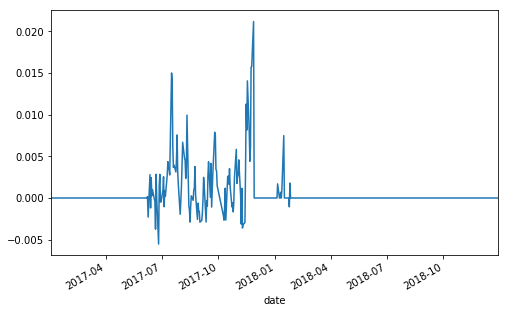

In [115]:
datas = load_dir(data_path)
tags = datas.symbol.unique()
tag = tags[0]

data = datas[datas.symbol== tag]
df = init_back_data(data, swin, mwin, lwin)
print(tag)

test_data = back_test(df, start='2017', to='2018')
#test_data[['sma','mma','lma','c']].plot(figsize=(8,5))
#plt.show()
#test_data.value.plot(figsize=(8,5))
print(test_data.drawdown.describe())
test_data.drawdown.plot(figsize=(8,5))
print(test_data.value[-1])
#plt.show()
    

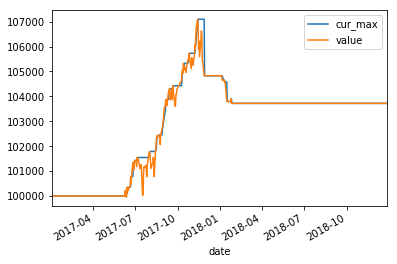

In [99]:
test_data[['cur_max','value']].plot()

In [79]:
test_data['2017-06-07':'2017-07-11'][ ['value', 'cur_max']]

,value,cur_max
date,,
2017-06-07,100000,72842
2017-06-08,99983,72842
2017-06-09,100229,72842
2017-06-12,99949,72842
2017-06-13,100348,72842
2017-06-14,100102,72842
2017-06-15,100323,72842
2017-06-16,100246,72842
2017-06-19,100357,69281


In [80]:
test_data.value['2017-06-07':'2017-06-12'].max()

100229

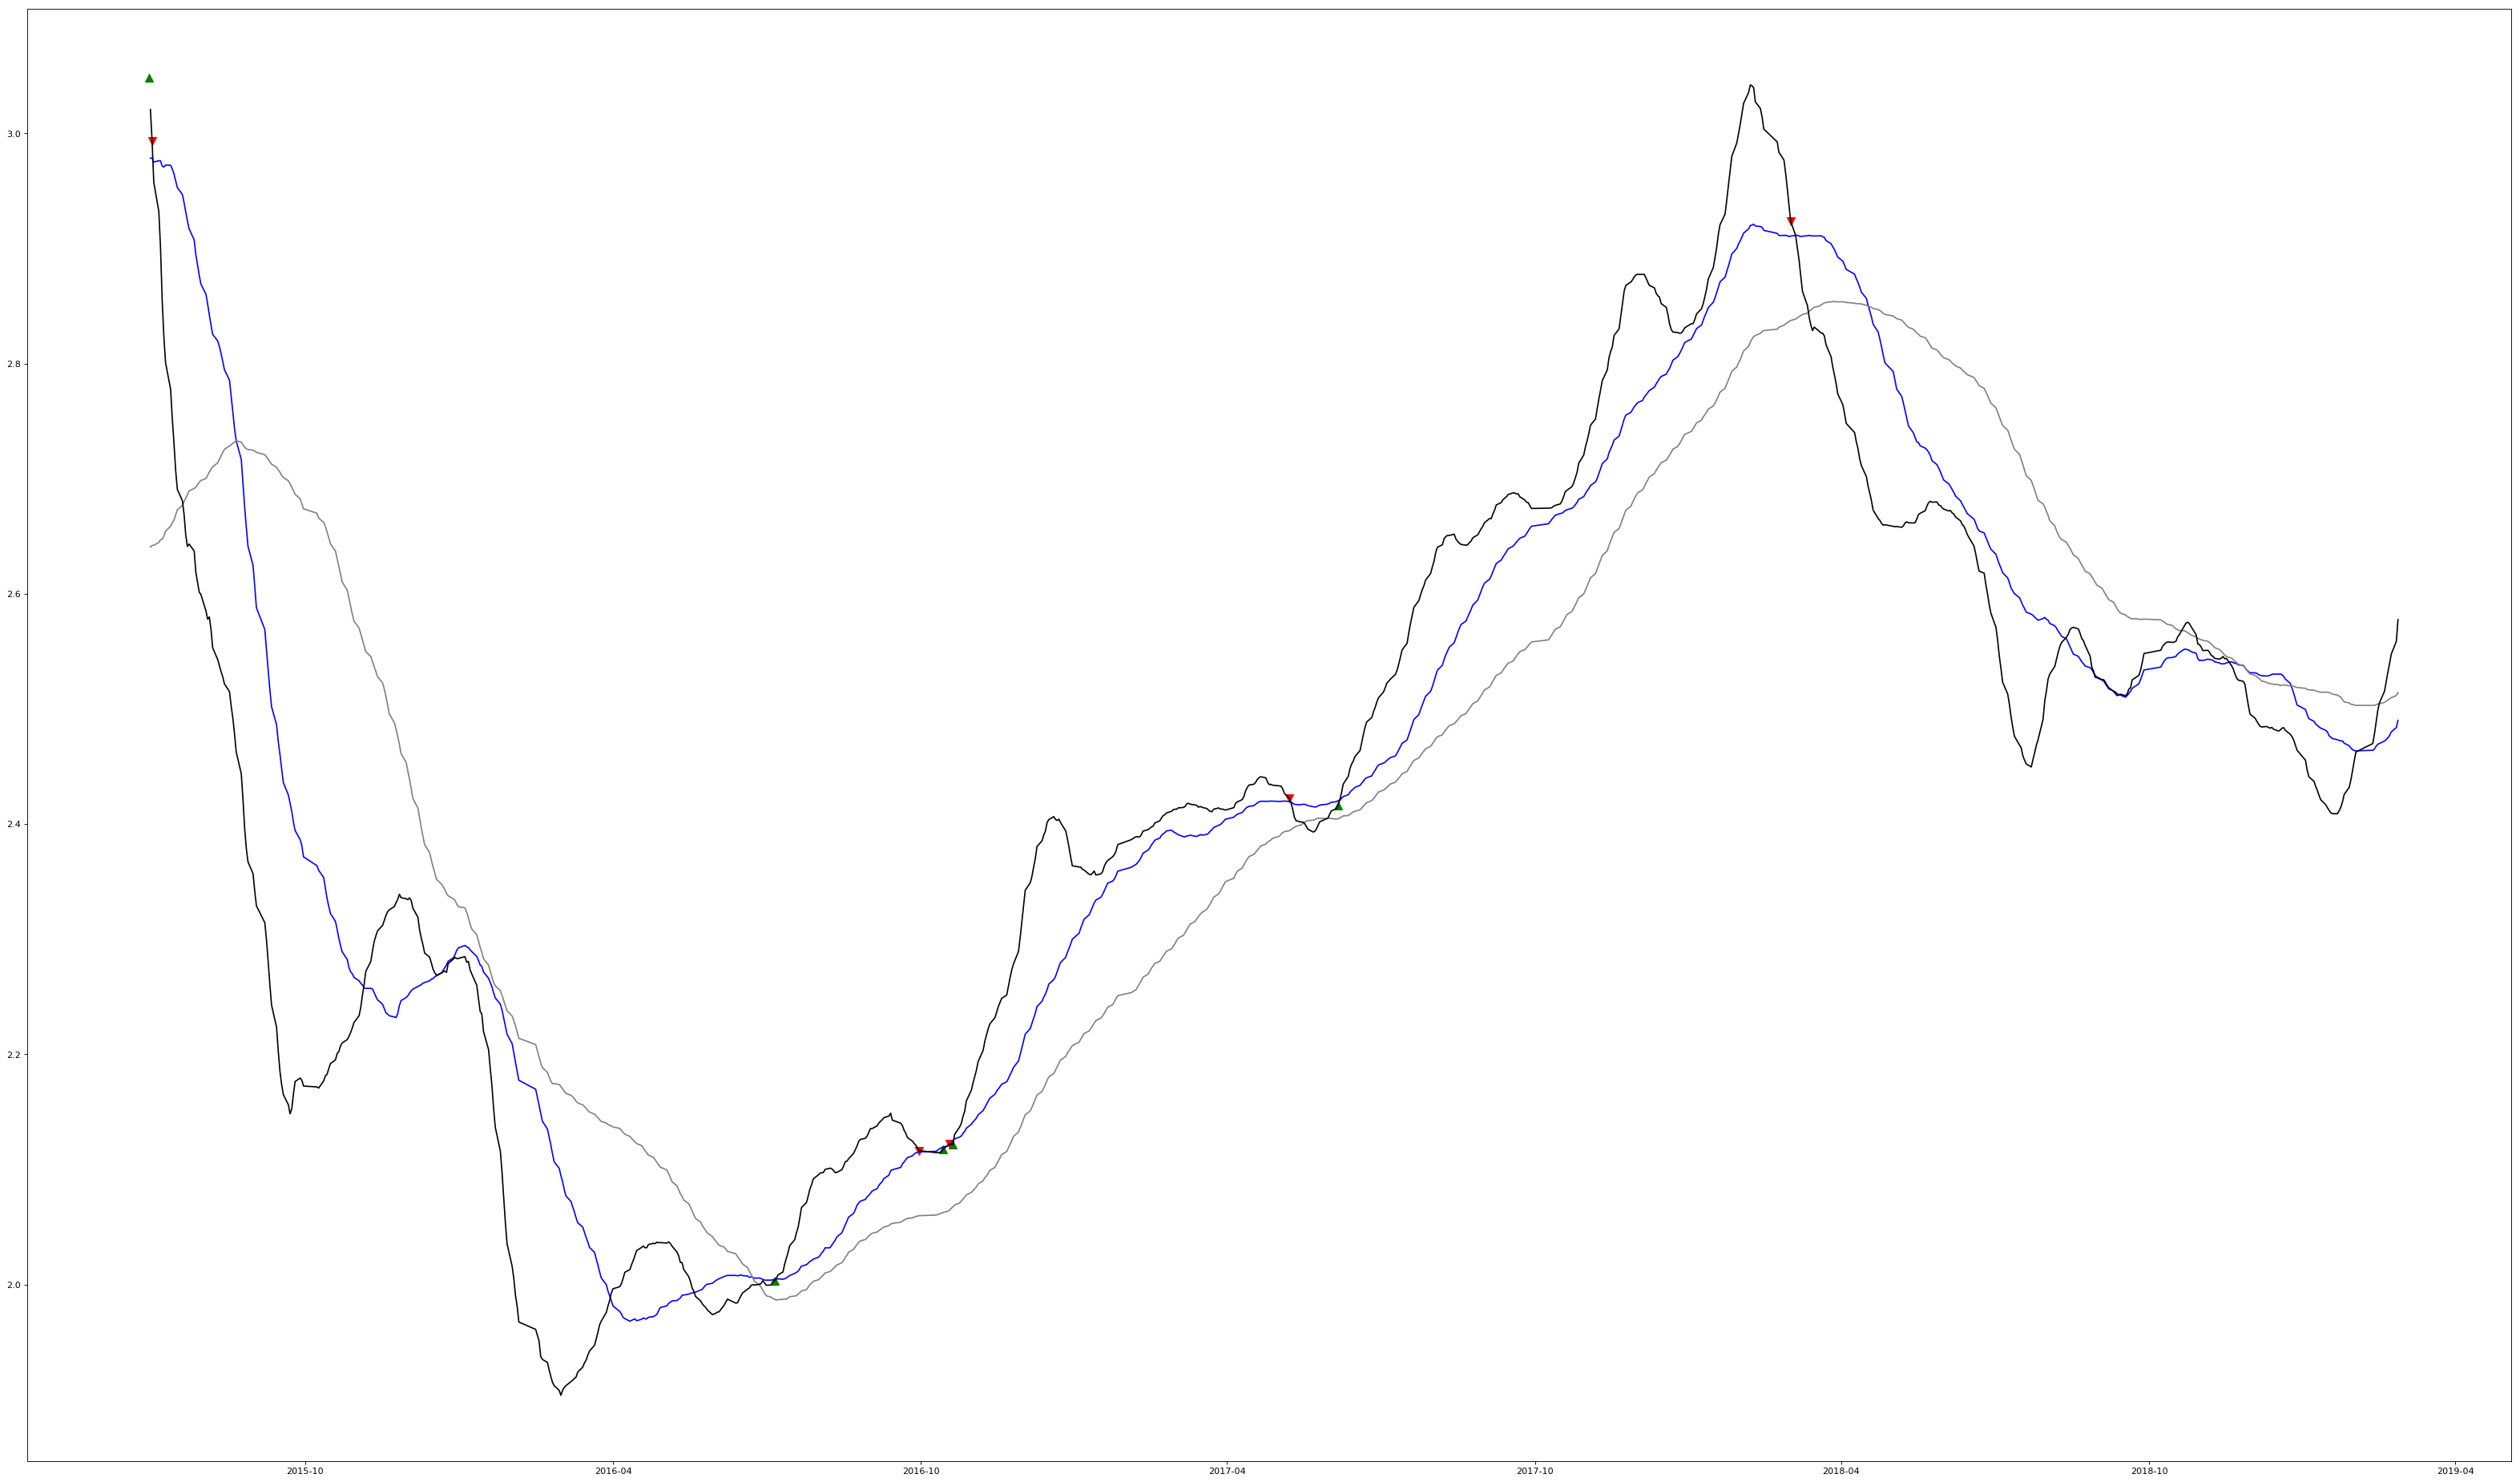

In [170]:
f = plt.figure(figsize=(50, 30), dpi= 80, facecolor='w', edgecolor='k')
plt.scatter(buy_at.index, buy_at, marker='^',s=80,c='green')
plt.scatter(sell_at.index,sell_at, marker='v',s=80,c='red')
plt.plot(sr.lma.index, sr.mma, c='blue')
plt.plot(sr.lma.index, sr.lma, c='gray')
plt.plot(sr.lma.index, sr.sma, c= 'black')

plt.show()
f.savefig("sig.pdf", bbox_inches='tight')

In [48]:
from math import floor
floor(1000/(3.5*100))

2